# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откроем файл с данными и изучим общую информацию

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

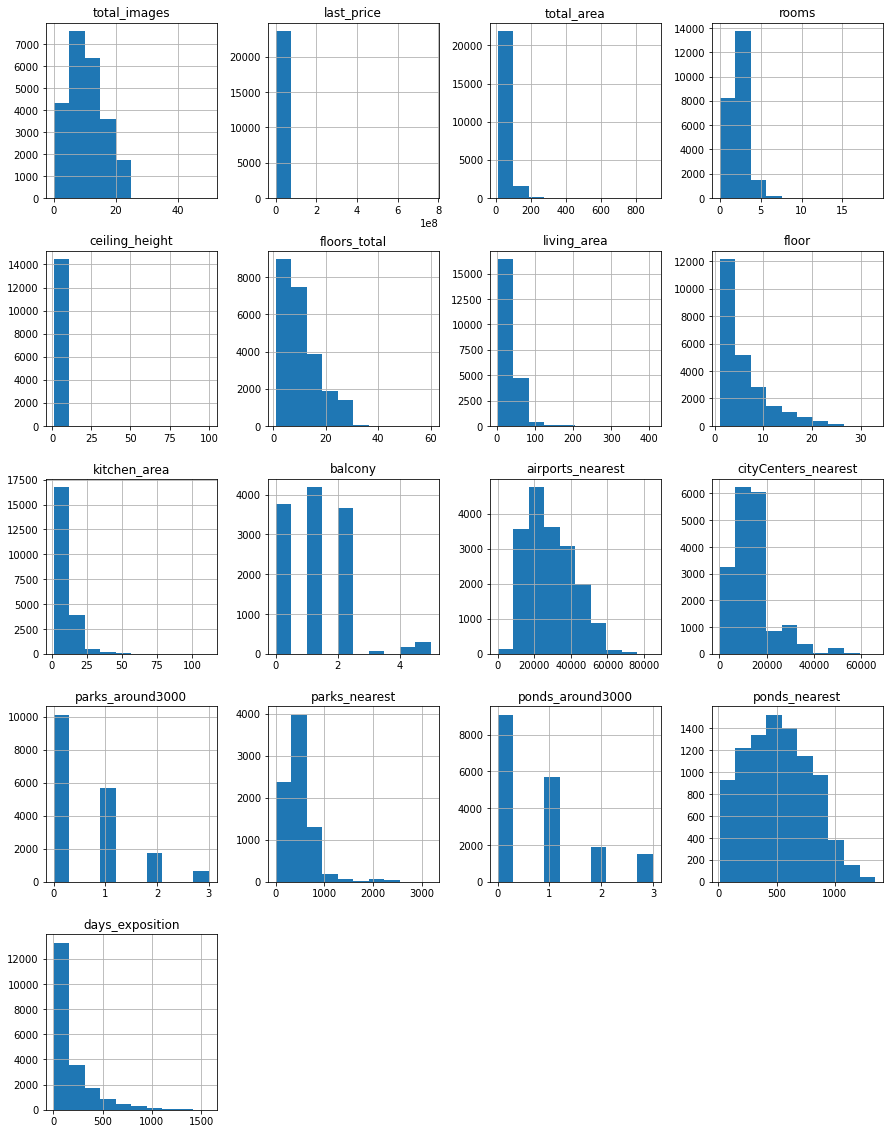

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.head(5))
print(data.describe())
print(data.info())
data.hist(figsize=(15, 20))

Видно большое количество пропусков: в аппартаментах, ближайших парках, балконах, ближайших прудах. Также видны квартиры с 0 комнат и 19-комнатные, метровые и 100-метровые потолки, что выглядит неправдоподобно, есть над чем поработать.


### Выполним предобработку данных

In [2]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [4]:
shape = data.shape 

print('\nNumber of rows :', shape[0])

data.info()


Number of rows : 23699
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 


<div class="alert alert-block alert-info">
Количество строк до переработки данных равно 23699.
    
</div>


Присутствует большое количество пропусков, будем разбираться по порядку:
- ceiling_height   -     9195 - огромное количество прорпусков, скорее всего люди, дающие объявления, не посчитали необходимым вносить высоту потолков, пропущенных данных очень много, поэтому считаю необходимым, заполнить пропуски медианным значением. 
- floors_total     -     86 - тут пропусков не так много, тоже списываю на человеческий фактор,не вижу возможности вносить медиану на место пропусков, тк информация исказится.
- living_area      -     1903 - тут пропусков не так много, тоже списываю на человеческий фактор, возможно заполнить пропуски коэффициентом соотношения с общей площадью, так как она везде известна.
- is_apartment     -     20924 - огромное число пропусков, вероятно, люди, имеющие квартиру, а не апартаменты не сочли нужным заполнять данную информацию, поэтому считаю возможным заменить пропуски 0.
- kitchen_area     -     2278 - вероятно люди не посчитали нужным замерять площадь кухни, возможно заполнить пропуски коэффициентом соотношения с общей площадью, так как она везде известна.
- balcony         -      11519 - тут возможно у человека нет балкона и поэтому стоит пропуск, можно заменить пропуски 0.
- locality_name    -     49 - вероятно, тк все квартиры в Спб, люди не задумались, что есть населенные пункты и область, не вижу возможности вносить медиану на место пропусков, тк информация исказится.
- parks_around3000  -    5518, parks_around3000   -   5518 - данные по пропускам прудов и парков в радиусе 3000км одинаковы, что странно, тк есть парки и без прудов, поэтому можно предположить, что данные не были выгружены.
- parks_nearest     -    15620 - скорее всего люди не сочли эту информацию важной.
- ponds_nearest     -    14589 - скорее всего люди не сочли эту информацию важной.
Я также считаю информацию о парках и прудах не очень важной, есть возможность провести анализ без неё.

In [3]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(0)

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски, в категории балкон и апартаменты заполнены.

In [4]:
med = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(med) #заполняем пропуски высоты потолка 
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
kk = data['kitchen_area'].sum()/data['total_area'].sum()
kl = data['living_area'].sum()/data['total_area'].sum()
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*kk)
data['living_area'] = data['living_area'].fillna(data['total_area']*kl)
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Чтобы заполнить пропуски площади кухни и жилой площади, я нашла коэффициент соотношения этих площадей с общей площадью квартиры и умножила его на общую площадь, так данные будут максимально точными, насколько это возможно. 

In [6]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,0,...,25.00000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,0,...,11.00000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.300000,4,0,...,8.30000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,83.495783,9,0,...,25.17134,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,0,...,41.00000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Преобразую тип данных в выбранных столбцах
last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition - переводим в целочисленный тип (int) (кол-во балконов, прудов, парков и тд - целые числа)
first_day_exposition - даты в datetime (для наглядности и понятности дат)


In [7]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #изменяю формат дат

float_to_int = ['last_price', 'floors_total', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
               'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']
for column in float_to_int:
    data[column] = data[data[column].notnull()][column].astype('int')
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.000000,8,0,...,25.00000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11.0,18.600000,1,0,...,11.00000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5.0,34.300000,4,0,...,8.30000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14.0,83.495783,9,0,...,25.17134,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.000000,13,0,...,41.00000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Неявные дубликаты: одинаковые названия городов и областей, написанные по-разному.

In [8]:
len(data['locality_name'].unique())


365

In [9]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок Мурино'], 'Мурино', regex=True)
    .replace(['поселок городского типа Рябово'], 'поселок Рябово', regex=True)
    .replace(['деревня Кудрово'], 'Кудрово', regex=True)
) 
len(data['locality_name'].unique())

328

### Добавьте в таблицу новые столбцы

In [10]:
data['price_of_sqrm'] = data['last_price']/data['total_area'] #цена одного квадратного метра
data['price_of_sqrm'] = data['price_of_sqrm'].round(2)
#---
data['first_day_exposition'] = pd.to_datetime( #месяц публикации объявления;
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
#---
data['first_day_exposition'] = pd.to_datetime( #год публикации объявления;
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year
#---
data['first_day_exposition'] = pd.to_datetime( #день публикации объявления;
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
data['day'] = pd.DatetimeIndex(data['first_day_exposition']).day

dict_of_weekdays = {1: 'понедельник', 2: 'вторник', 3: 'среда', 4: 'четверг', 5: 'пятница', 6: 'суббота',
7: 'воскресенье', 8: 'понедельник', 9: 'вторник', 10: 'среда', 11: 'четверг', 12: 'пятница', 13: 'суббота', 
14: 'воскресенье', 15: 'понедельник', 16: 'вторник', 17: 'среда', 18: 'четверг', 19: 'пятница', 20: 'суббота', 
21: 'воскресенье', 22: 'понедельник', 23: 'вторник', 24: 'среда', 25: 'четверг', 26: 'пятница', 27: 'суббота', 
28: 'воскресенье', 29: 'понедельник', 30: 'вторник', 31: 'среда'}
data['day'] = data['day'].map(dict_of_weekdays)

#---
data['floor_type'] = np.where(data['floor'] == 1, 'первый', 'другой') #тип этажа
data['floor_type'] = np.where(data['floor'] == data['floors_total'], 'последний', data['floor_type'])

#---
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000 #расстояние до центра города в километрах
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].round()


print(data.head())





   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0    51.000000      8            0  ...   
1            2.65          11.0    18.600000      1            0  ...   
2            2.65           5.0    34.300000      4            0  ...   
3            2.65          14.0    83.495783      9            0  ...   
4            3.03          14.0    32.000000     13            0  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0               2.0          755.0              N

### Проведите исследовательский анализ данных

,ceiling_height
count,23699.000000
mean,2.724358
std,0.988298
min,1.000000
25%,2.600000
50%,2.650000
75%,2.700000
max,100.000000


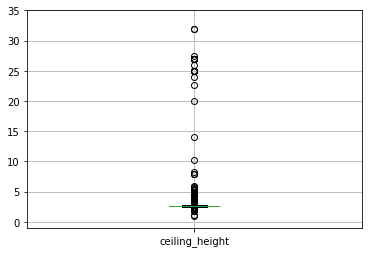

In [11]:
plt.ylim(-1, 35)
data.boxplot(column='ceiling_height')
data[['ceiling_height']].describe()

Видно, что есть выбросы, вероятно потолки выше 6м случайно записали целым а не вещественным значением (32м > 3,2м), 
заменим эти значения, так же существуют потолки 1 м, чего быть не может, потавим ограничение >= 2м.

In [12]:
data['ceiling_height'] = pd.to_numeric(data['ceiling_height'])

data = data.loc[data['ceiling_height'] >= 2] #удаляем строки с высотой потолков меньше 2, так как скорее всего это ошибка в данных
data[['ceiling_height']].describe()

,ceiling_height
count,23696.000000
mean,2.724537
std,0.988228
min,2.000000
25%,2.600000
50%,2.650000
75%,2.700000
max,100.000000


In [13]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_sqrm,month,year,day,floor_type,cityCenters_nearest_km
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.000000,8,0,...,482.0,2.0,755.0,NaN,120370.37,3,2019,воскресенье,другой,16.0
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.600000,1,0,...,NaN,0.0,NaN,81.0,82920.79,12,2018,четверг,первый,19.0
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.300000,4,0,...,90.0,2.0,574.0,558.0,92785.71,8,2015,суббота,другой,14.0
3,0,64900000,159.00,2015-07-24,3,2.65,14.0,83.495783,9,0,...,84.0,3.0,234.0,424.0,408176.10,7,2015,среда,другой,7.0
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.000000,13,0,...,112.0,1.0,48.0,121.0,100000.00,6,2018,пятница,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.300000,3,0,...,796.0,3.0,381.0,NaN,72490.85,3,2017,воскресенье,другой,4.0
23695,14,3100000,59.00,2018-01-15,3,2.65,5.0,38.000000,4,0,...,NaN,NaN,NaN,45.0,52542.37,1,2018,понедельник,другой,NaN
23696,18,2500000,56.70,2018-02-11,2,2.65,3.0,29.700000,1,0,...,NaN,NaN,NaN,NaN,44091.71,2,2018,четверг,первый,NaN
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,40.303782,12,0,...,173.0,3.0,196.0,602.0,149511.40,3,2017,воскресенье,другой,10.0


<AxesSubplot:>

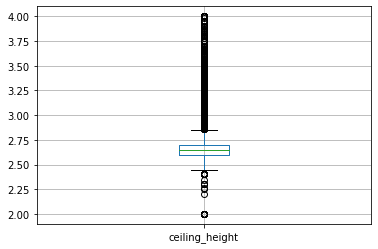

In [14]:

def hieght_fnc(row):
    hieght = row['ceiling_height']
    if 20 <= hieght <= 40:
        return hieght/10
    if 4 < hieght < 20:
        return med
    if hieght > 40:
        return med
    else:
        return  hieght
data['ceiling_height'] = data.apply(hieght_fnc, axis=1)
data[['ceiling_height']].describe()
data.boxplot(column='ceiling_height')


Данной функцией я изманила высоту потолков, тк 3-4 м - предельная высота потолков, и ошибка могла произойти лишь в случае 20-40м (хотели написать вещественное число), в остальных случаях нереальную высоту я заменила на медиану.
По ящику с усами, можно заметить, что от выбросов я избавилась.

,total_area
count,23696.000000
mean,60.350476
std,35.655896
min,12.000000
25%,40.000000
50%,52.000000
75%,69.900000
max,900.000000


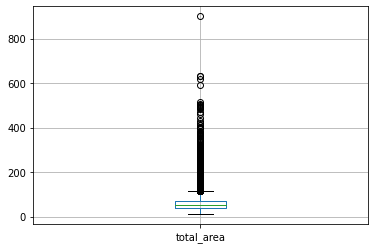

In [15]:

data.boxplot(column='total_area')
data[['total_area']].describe()

Выброс в 900 м^2 кажется странным, похоже на ошибку ввода, удалим эту строку.

In [16]:
data['total_area'] = pd.to_numeric(data['total_area'])

data = data.loc[data['total_area'] < 900] 
data[['total_area']].describe()

,total_area
count,23695.000000
mean,60.315040
std,35.236919
min,12.000000
25%,40.000000
50%,52.000000
75%,69.900000
max,631.200000


Общая площадь от 12 до 631 м^2, что вполне возможно, большие площади элитных жк или коммунальные квартиры, а маленькие в однушках и студиях.

,living_area
count,23695.000000
mean,34.346205
std,22.035323
min,2.000000
25%,18.904706
50%,30.000000
75%,42.000000
max,409.000000


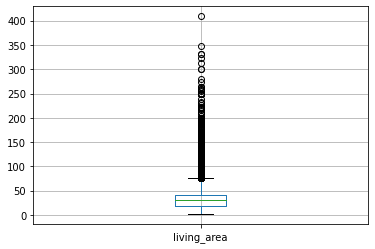

In [17]:
data.boxplot(column='living_area')
data[['living_area']].describe()

Данные кажутся мне корректными, площадь жилой зоны от 2 до 409 м^2.

,kitchen_area
count,23695.000000
mean,10.410772
std,5.944597
min,1.300000
25%,7.000000
50%,9.000000
75%,11.900000
max,107.000000


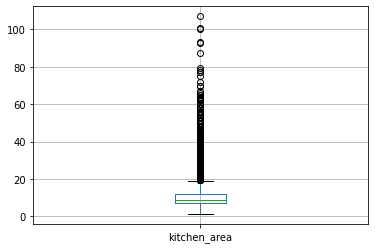

In [18]:
data.boxplot(column='kitchen_area')
data[['kitchen_area']].describe()

Минимальная площадь кухни в 1 кв м кажется нерельной, уберем значения меньше 2 кв м.

In [19]:
data['kitchen_area'] = pd.to_numeric(data['kitchen_area'])

data = data.loc[data['kitchen_area'] > 2] 
data[['kitchen_area']].describe()

/tmp/ipykernel_60/15827425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['kitchen_area'] = pd.to_numeric(data['kitchen_area'])


,kitchen_area
count,23686.000000
mean,10.414001
std,5.943415
min,2.058034
25%,7.000000
50%,9.000000
75%,11.900000
max,107.000000


,last_price
count,2.368600e+04
mean,6.525803e+06
std,1.055308e+07
min,1.219000e+04
25%,3.406500e+06
50%,4.650000e+06
75%,6.800000e+06
max,7.630000e+08


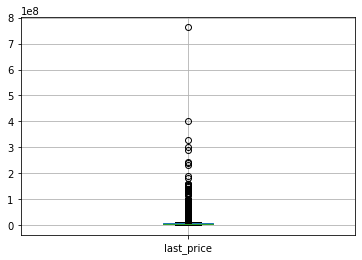

In [20]:
data.boxplot(column='last_price')
data[['last_price']].describe()

Данные по цене кажутся корректными.

,rooms
count,23686.000000
mean,2.070632
std,1.076567
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,19.000000


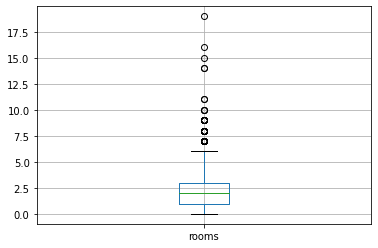

In [21]:
data.boxplot(column='rooms')
data[['rooms']].describe()

Минимульное число комнат - 0, уберем эти строки, количество комнат должно превышать 0, большое количество комнат возможно, если это элитная квартира или коммуналка.

In [22]:
data['rooms'] = pd.to_numeric(data['rooms'])

data = data.loc[data['rooms'] > 0] 
data[['rooms']].describe()

,rooms
count,23489.000000
mean,2.087999
std,1.064169
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,19.000000


            count
            floor
floor_type       
другой      17271
первый       2870
последний    3348


<AxesSubplot:xlabel='floor_type'>

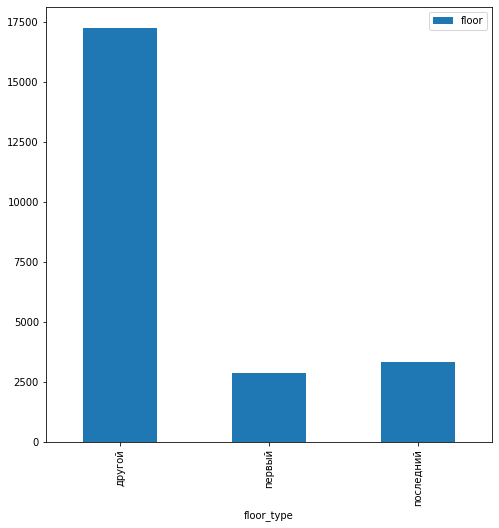

In [23]:
stat_data = data.pivot_table(index='floor_type', values='floor', aggfunc=['count'])
print(stat_data)                            
stat_data.plot(orders, kind='bar', figsize=(8, 8))


На графика показано соотношение типа этажей.

,floors_total
count,23406.000000
mean,10.620952
std,6.567205
min,1.000000
25%,5.000000
50%,9.000000
75%,16.000000
max,60.000000


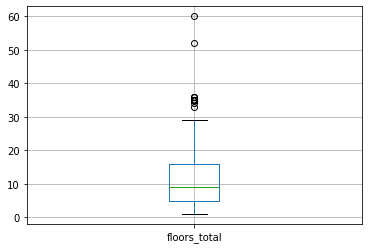

In [23]:
data.boxplot(column='floors_total')
data[['floors_total']].describe()

Считаю, что данные корректны, тк число этажей варьируется от 1 до 60, среднее количество этажей 10, всё в пределах норамы.

,cityCenters_nearest
count,18050.000000
mean,14198.945928
std,8627.750996
min,181.000000
25%,9234.000000
50%,13094.000000
75%,16293.000000
max,65968.000000


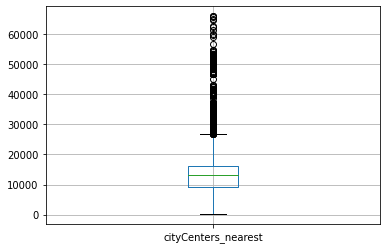

In [24]:
data.boxplot(column='cityCenters_nearest')
data[['cityCenters_nearest']].describe()

Большое количество квартир находятся далеко от центра, что возможно, тк квартиры продаются не только в самом городе, но и в области.

,parks_nearest
count,8046.000000
mean,490.397092
std,342.457422
min,1.000000
25%,287.250000
50%,454.000000
75%,612.000000
max,3190.000000


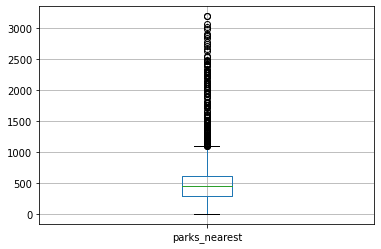

In [25]:
data.boxplot(column='parks_nearest')
data[['parks_nearest']].describe()

Я считаю растояние от 1м до 3км до парка приемлемым.

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23489 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23489 non-null  int64         
 1   last_price              23489 non-null  int64         
 2   total_area              23489 non-null  float64       
 3   first_day_exposition    23489 non-null  datetime64[ns]
 4   rooms                   23489 non-null  int64         
 5   ceiling_height          23489 non-null  float64       
 6   floors_total            23406 non-null  float64       
 7   living_area             23489 non-null  float64       
 8   floor                   23489 non-null  int64         
 9   is_apartment            23489 non-null  object        
 10  studio                  23489 non-null  bool          
 11  open_plan               23489 non-null  bool          
 12  kitchen_area            23489 non-null  float6

In [27]:
shape = data.shape 

print('\nNumber of rows :', shape[0])

data.info()



Number of rows : 23489
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23489 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23489 non-null  int64         
 1   last_price              23489 non-null  int64         
 2   total_area              23489 non-null  float64       
 3   first_day_exposition    23489 non-null  datetime64[ns]
 4   rooms                   23489 non-null  int64         
 5   ceiling_height          23489 non-null  float64       
 6   floors_total            23406 non-null  float64       
 7   living_area             23489 non-null  float64       
 8   floor                   23489 non-null  int64         
 9   is_apartment            23489 non-null  object        
 10  studio                  23489 non-null  bool          
 11  open_plan               23489 non-null  bool          
 12  kitchen_area          

<div class="alert alert-block alert-info">
    
После переработки осталось 23489 строк (изначально было 23699), что составляет более 90% от изначального числа данных, поэтому можно провести актуальный анализ.
    
</div>

<div class="alert alert-success">

**✔️ Комментарий ревьюера v2✔️**
   
   Хороший результат👍

</div>


Медиана: 96.0
среднее: 181.58323082222114


count    20323.000000
mean       181.583231
std        220.143499
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

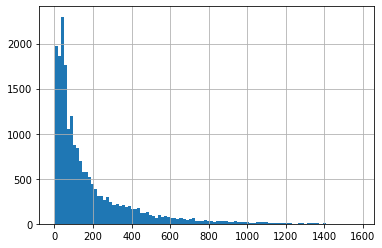

In [28]:
data['days_exposition'].hist(bins=100)
a = data['days_exposition'].median()
b = data['days_exposition'].mean()
print('Медиана:', a)
print('среднее:', b)
data['days_exposition'].describe()

count    20323.000000
mean       181.583231
std        220.143499
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

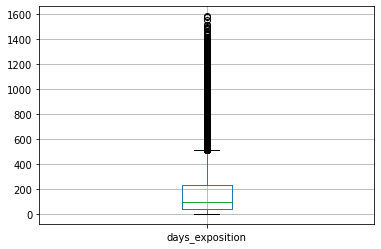

In [29]:
data.boxplot(column='days_exposition')
data['days_exposition'].describe()

<div class="alert alert-block alert-info">
В среднем продажа занимает 3 месяца. По диаграмме размаха видно, что быстрые продажи до 1,5 месяцев (1 квартиль), а долгими будут считаться продажи более 7,5 месяцев (3 квартиль), существует даже квартира, продававшаяся 5 лет. Вижу пики в значениях, посмотрим поближе.
</div>

<AxesSubplot:>

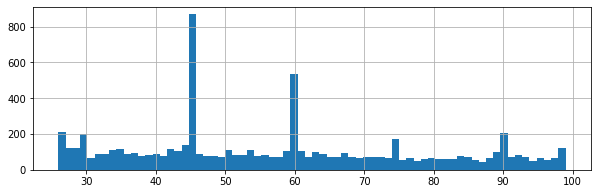

In [29]:
data.query('25<days_exposition<100')['days_exposition'].hist(bins=70, figsize=(10,3))

<div class="alert alert-block alert-info">
Видно, что через 45, 60 и 90 дней продается большое количество квартир, возможно это связано с работой "Яндекс Недвижимость", эти пики являются следами автоматического снятия объявлений.
</div>

Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта.
Изучите, зависит ли цена от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).
Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

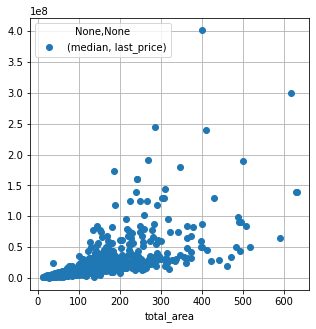

In [30]:
stat_totarea = data.pivot_table(index='total_area', values='last_price', aggfunc=['median']).plot(grid=True, style = 'o', figsize = (5,5))


Видно, что цена зависит от общей площади. Чем больше площадь, тем больше цена.

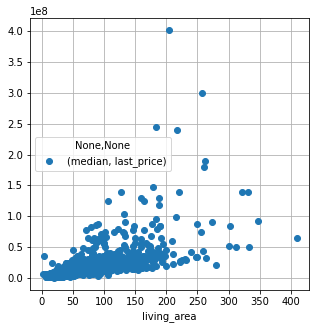

In [31]:
stat_livarea = data.pivot_table(index='living_area', values='last_price', aggfunc=['median']).plot(grid=True, style = 'o', figsize = (5,5))

Видно, что цена зависит от жилой площади. Чем больше площадь, тем больше цена.

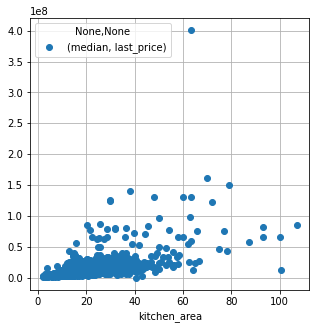

In [32]:
stat_kitarea = data.pivot_table(index='kitchen_area', values='last_price', aggfunc=['median']).plot(grid=True, style = 'o', figsize = (5,5))

Видно, что цена зависит от кухонной площади. Чем больше площадь, тем больше цена.

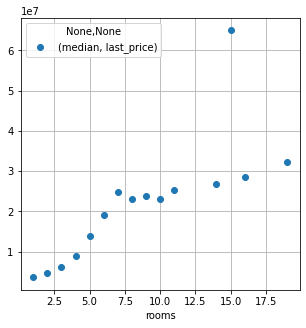

In [33]:
stat_rooms = data.pivot_table(index='rooms', values='last_price', aggfunc=['median']).plot(grid=True, style = 'o', figsize = (5,5))

Видно, что цена зависит от количества комнат. Чем больше комнат, тем больше цена.

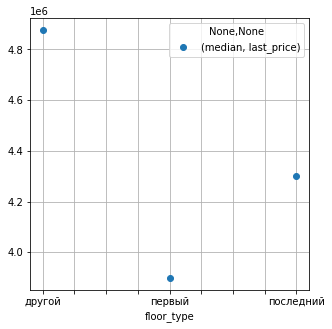

In [34]:
stat_ft = data.pivot_table(index='floor_type', values='last_price', aggfunc=['median']).plot(grid=True, style = 'o', figsize = (5,5))

Нельзя сказать точно, о влиянии цены на тип этажа, но цена на квартиру на первом этаже значительно ниже, чем на последнем.

<div class="alert alert-success">

**✔️ Комментарий ревьюера ✔️**

   Хорошие результаты. Отмечу, что скорее всего, низкую цену на квартиры на первом и последнем этажах можно аргументировать плохими условиями - шум от улиц и моторов лифта, охлаждаемость помещения зимой.

</div>

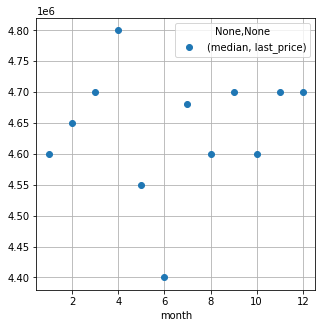

In [35]:
stat_month = data.pivot_table(index='month', values='last_price', aggfunc=['median']).plot(grid=True, style = 'o', figsize = (5,5))

Я не считаю, что месяц размещения влияет на цену.

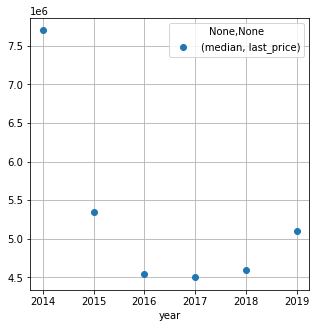

In [36]:
stat_year = data.pivot_table(index='year', values='last_price', aggfunc=['median']).plot(grid=True, style = 'o', figsize = (5,5))

А вот в 2014 году цены были самыми высокими, потом пошли на спад и к 2017 году снова стали расти.
Это можно объяснить Валютным кризисом в России (2014—2015) — резкое ослабление российского рубля, к 2017 голу ситуация стабилизировалась и пошел рост покупательской способности.

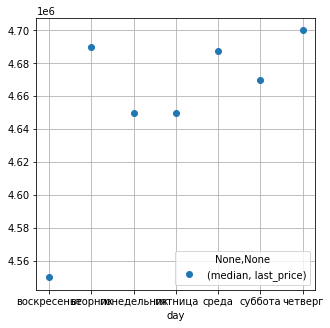

In [37]:
stat_day = data.pivot_table(index='day', values='last_price', aggfunc=['median']).plot(grid=True, style = 'o', figsize = (5,5))

Я не считаю, что месяц размещения влияет на цену.

In [38]:

data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_sqrm,month,year,cityCenters_nearest_km
total_images,1.000000,0.107938,0.115390,0.095403,0.050240,0.013497,0.104905,0.033687,-0.015802,-0.012589,...,-0.048378,0.021078,-0.007348,-0.010638,-0.002429,-0.028202,0.133783,0.005364,0.141759,-0.047829
last_price,0.107938,1.000000,0.642457,0.361555,0.275592,-0.008040,0.577227,0.022696,-0.007694,0.007529,...,-0.212582,0.157072,-0.016456,0.163669,-0.086694,0.084229,0.750671,0.000753,-0.043833,-0.212876
total_area,0.115390,0.642457,1.000000,0.761218,0.382403,-0.072059,0.943451,-0.024786,-0.020421,0.004189,...,-0.235182,0.166415,-0.021178,0.164558,-0.100033,0.150881,0.301556,0.004983,-0.080262,-0.235027
rooms,0.095403,0.361555,0.761218,1.000000,0.251281,-0.219620,0.834512,-0.147340,-0.022131,0.007146,...,-0.188820,0.134767,-0.052725,0.094600,-0.058516,0.124050,0.056842,-0.001707,-0.054313,-0.188384
ceiling_height,0.050240,0.275592,0.382403,0.251281,1.000000,-0.077223,0.361632,-0.045498,-0.000235,0.005682,...,-0.298768,0.228499,-0.059906,0.193718,-0.118643,0.110269,0.282277,-0.005522,-0.052094,-0.299147
floors_total,0.013497,-0.008040,-0.072059,-0.219620,-0.077223,1.000000,-0.159030,0.679117,0.016861,0.005291,...,0.018381,-0.250861,0.095079,-0.123975,0.041602,-0.050751,0.147284,0.015376,0.007592,0.017732
living_area,0.104905,0.577227,0.943451,0.834512,0.361632,-0.159030,1.000000,-0.090956,-0.015087,0.006145,...,-0.231320,0.180208,-0.049686,0.149067,-0.084449,0.146082,0.230019,-0.000012,-0.074283,-0.230999
floor,0.033687,0.022696,-0.024786,-0.147340,-0.045498,0.679117,-0.090956,1.000000,0.011506,0.000497,...,0.008282,-0.162764,0.071279,-0.076561,0.027469,-0.039095,0.127397,0.018426,0.004961,0.007798
studio,-0.015802,-0.007694,-0.020421,-0.022131,-0.000235,0.016861,-0.015087,0.011506,1.000000,-0.000400,...,-0.000924,-0.004426,-0.005287,0.000539,-0.001582,-0.011325,0.000766,-0.008076,-0.030266,-0.000757
open_plan,-0.012589,0.007529,0.004189,0.007146,0.005682,0.005291,0.006145,0.000497,-0.000400,1.000000,...,-0.003763,0.001206,-0.011185,0.004476,-0.009285,-0.001191,0.008607,-0.005384,-0.030842,-0.003223


total_area : 0.642457	
rooms : 0.361555
month :	0.000753	
living_area : 0.577227
year	:  -0.043833	
Согласно коэффициенту кореляции можно сделать вывод, что кол-во комнат и общая площадь квартиры больше всего влияют на общую (полную) стоимость объекта.

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — постройте сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [39]:
pivot = data.pivot_table(index=['locality_name'], values=['price_of_sqrm'], aggfunc=['median','count'])
pivot. columns = ['_'.join(str(s). strip () for s in col if s) for col in pivot. columns ]
pivot = pivot.sort_values(by=['count_price_of_sqrm'], ascending=False)
print(pivot.head(10)) 
print()
maxp = pivot[pivot['median_price_of_sqrm'] == pivot['median_price_of_sqrm']. max()]
print('самая высокая стоимость квадратного метра', maxp)
minp = pivot[pivot['median_price_of_sqrm'] == pivot['median_price_of_sqrm']. min()]
print('самая низкая стоимость квадратного метра', minp)

                   median_price_of_sqrm  count_price_of_sqrm
locality_name                                               
Санкт-Петербург              104638.620                15599
Мурино                        84801.380                  562
Кудрово                       95348.840                  451
поселок Шушары                76747.970                  436
Всеволожск                    65789.470                  392
Пушкин                       100000.000                  369
Колпино                       74723.745                  338
поселок Парголово             91917.590                  323
Гатчина                       67796.610                  307
Выборг                        58158.320                  237

самая высокая стоимость квадратного метра                  median_price_of_sqrm  count_price_of_sqrm
locality_name                                             
Санкт-Петербург             104638.62                15599
самая низкая стоимость квадратного метра        

Среди 10 населённых пунктов с наибольшим числом объявлений самую высокую стоимость квадкотного метра имеют Спб и Пушкин, самую низкую - Выборг и Всеволожск. Среди всех предстваленных для анализа населенных пунктов самую высокую стоимость имеет Спб, а самую низкую - деревня Ставрополье.

<div class="alert alert-success">

**✔️ Комментарий ревьюера ✔️**
   
   Верно

</div>


Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите их среднюю стоимость на разном удалении от центра. Учитывайте каждый километр расстояния: узнайте среднюю цену квартир в одном километре от центра, в двух и так далее. Опишите, как стоимость объектов зависит от расстояния до центра города — постройте график изменения средней цены для каждого километра от центра Петербурга

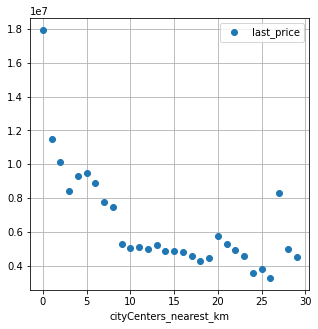

In [40]:
data_spb = data.query('locality_name == "Санкт-Петербург"')
data_spb = data_spb.pivot_table(index = 'cityCenters_nearest_km', values = 'last_price', aggfunc = 'median').plot(grid=True, style = 'o', figsize = (5,5))


Стоимость объектов меняется в зависимости от расположения, чем ближе расположена квартира от центра, тем выше цена, чем дальше, тем цена ниже. Так цена на квартиру в самом центре близится к 20 млн, а в 30 км от центра она не более 5 млн.

<div class="alert alert-success">
✔️ Комментарий ревьюера ✔️

Верно. На графике после 7 км заметно, что цена меняется. Это возможный центр города.

Если интересно, то самый дорогой по стоимости жилья район в Санкт-Петербурге риелторы назвали "Золотой треугольник". Дома "Золотого треугольника" находятся в пределах Невского проспекта, набережной реки Фонтанки и Дворцовой набережной.
Для географической справки: https://zen.yandex.ru/media/id/5cb4ebcc0a51a300b5b1f60d/zolotoi-treugolnik-sanktpeterburga-chto-eto-i-gde-nahoditsia-5edf942db1204610073e88b2

</div>

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23489 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23489 non-null  int64         
 1   last_price              23489 non-null  int64         
 2   total_area              23489 non-null  float64       
 3   first_day_exposition    23489 non-null  datetime64[ns]
 4   rooms                   23489 non-null  int64         
 5   ceiling_height          23489 non-null  float64       
 6   floors_total            23406 non-null  float64       
 7   living_area             23489 non-null  float64       
 8   floor                   23489 non-null  int64         
 9   is_apartment            23489 non-null  object        
 10  studio                  23489 non-null  bool          
 11  open_plan               23489 non-null  bool          
 12  kitchen_area            23489 non-null  float6

Я избавилась от 210 строк, что несильно исказило информацию.

### Напишите общий вывод

** В исходных данных присутствовало большое количество пропусков, в ходе проведения анализа было принято решение: 
- заполнить пропуски высоты потолков медианным значением, так как пропущенных значений было много
- пропуски в жилой площади и площади кухни были запонены коэффициентом соотношения с общей площадью
- прокуски в балконах и аппартаментах были заполнены 0, тк скорее всего люди не имея их не заполнили данные
- также есть предположение, что информация о близости парков и прудов была утерена системой, тк кол-во пропусков совпадает

** Был установлен корректный тип данных для времени и целочисленных значений
** Были устранены некорректные типы данных в названиях населенных пунктов 
** С помощью графиков были удалены аномальные значения
** Для дальнейшего анализа были добавлены новые столбцы 
** Были изучены основные параметры с помощью графиков, анализируя параметры я избавилась от аномальных значений, а также исправила ошибки пользователей в написании высоты потолков с помощью функций 
** Изучая скорость продаж квартир, я сделала вывод, что в среднем продажа занимает 3 месяца, считаю, что быстрыми можно назвать продажи до 1 месяца, а долгими более 7 месяцев.
** Цена зависит от таких параметров, как 
- общая площадь; чем больше площадь, тем выше цена
- жилая площадь; чем больше площадь, тем выше цена
- площадь кухни; чем больше площадь, тем выше цена
- количество комнат; чем больше комнат, тем выше цена
- этаж, квартиры на первом этаже имеют самую низкую цену, затем идут квартиры на последнем этаже, и самую высокую цену имеют квартиры на других этажах
- а также был замечен спад на цены квартир в 2014 году, тк был крицис, и тенденция к увеличению стоимости квартир, начиная с 2017 года 

** Среди 10 населённых пунктов с наибольшим числом объявлений самую высокую стоимость квадратного метра имеют Спб и Пушкин, самую низкую - Выборг и Всеволожск. Среди всех предстваленных для анализа населенных пунктов самую высокую стоимость имеет Спб, а самую низкую - деревня Ставрополье.
** на цену влияет расположение квартиры, чем она ближе к центру, тем квартира дороже


<div class="alert alert-success">

**✔️ Комментарий ревьюера ✔️**
   
   Дарья, проведен основательный и подробный анализ. Все наглядно - графики и гистограммы подтверждают обоснованные выводы. Учти мои замечания. Возможно, придется немного подправить выводы. Жду твой проект на повторное ревью. Успехов!

</div>


<div class="alert alert-success">

**✔️ Комментарий ревьюера v2✔️**
   
   Дарья, замечания устранены 👍. Уверен, мои советы пригодятся тебе в новых проектах. Успехов в обучении! 😉 

</div>

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.